<a href="https://colab.research.google.com/github/rahulbsw/quantum-compute/blob/main/QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to create and execute a simple quantum circuit using Qiskit and the IBM Quantum Platform.

### Load IBM Quantum Credentials

This cell loads the necessary credentials for accessing the IBM Quantum Platform from Colab's secrets manager.

### Install Required Libraries

This cell installs the necessary Python libraries for quantum computing with Qiskit and interacting with the IBM Quantum Platform.

### Save IBM Quantum Account Credentials

This cell saves your IBM Quantum account credentials to allow Qiskit to authenticate with the IBM Quantum Platform.

### Create a Quantum Circuit

This cell defines a simple two-qubit quantum circuit with a Hadamard gate on the first qubit and a controlled-X gate between the two qubits.

### Define Observables

This cell defines a list of Pauli observables to be measured on the quantum circuit.

### Initialize Qiskit Runtime Service and Select Backend

This cell initializes the Qiskit Runtime service and selects the least busy available quantum backend (a real quantum device, not a simulator) to run the circuit on. It also generates a pass manager for transpiling the circuit to the target backend.

### Transpile the Circuit

This cell transpiles the quantum circuit to the instruction set architecture (ISA) of the selected backend. This optimizes the circuit for execution on the specific hardware.

### Execute the Circuit on the Backend

This cell initializes the Estimator primitive and runs the transpiled circuit with the defined observables on the selected backend. It prints the job ID for tracking the execution.

### Retrieve Job Result

This cell retrieves the results of the quantum job executed in the previous cell.

### Extract Pub Result

This cell extracts the result of the first (and in this case, only) publication from the job result.

### Plot Results

This cell extracts the expectation values and standard deviations from the results and plots the expectation values for each observable.

This cell loads the necessary credentials for accessing the IBM Quantum Platform from Colab's secrets manager.

In [ ]:
from google.colab import userdata
token=userdata.get('IBMQuantumAPIKey')
instance_crn=userdata.get('IBMInstance_CRN')
region="us-east"
account_name=userdata.get('IBMAccount')

This cell installs the necessary Python libraries for quantum computing with Qiskit and interacting with the IBM Quantum Platform.

In [ ]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install pylatexenc
!pip install qiskit[visualization] matplotlib

This cell saves your IBM Quantum account credentials to allow Qiskit to authenticate with the IBM Quantum Platform.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(
  token=token, # Your token is confidential.
  # Do not share your token in public code.
  instance=instance_crn, # Optionally specify the instance to use.
  #plans_preference="['plan-type1', 'plan-type2']", # Optionally set the types of plans to prioritize.  This is ignored if the instance is specified.
  region=region, # Optionally set the region to prioritize. This is ignored if the instance is specified.
  #name=account_name, # Optionally name this set of account credentials.
  set_as_default=True, # Optionally set these as your default credentials.
)

This cell defines a simple two-qubit quantum circuit with a Hadamard gate on the first qubit and a controlled-X gate between the two qubits.

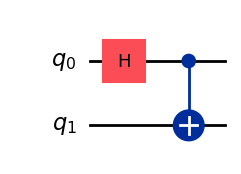

In [25]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

This cell defines a list of Pauli observables to be measured on the quantum circuit.

In [26]:
observables_labels=["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

This cell initializes the Qiskit Runtime service and selects the least busy available quantum backend (a real quantum device, not a simulator) to run the circuit on. It also generates a pass manager for transpiling the circuit to the target backend.

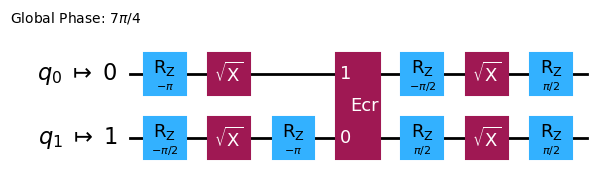

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

This cell transpiles the quantum circuit to the instruction set architecture (ISA) of the selected backend. This optimizes the circuit for execution on the specific hardware.

In [28]:
# This cell was previously generated and accepted by the user.
# It is included here for completeness, but no changes were made.

This cell initializes the Estimator primitive and runs the transpiled circuit with the defined observables on the selected backend. It prints the job ID for tracking the execution.

In [29]:
estimator = Estimator(mode=backend)
estimator.options.resilience_level=1
estimator.options.default_shots=5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d2dsge7fodsc73bfupg0


This cell retrieves the results of the quantum job executed in the previous cell.

In [30]:
job.result()

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

This cell extracts the result of the first (and in this case, only) publication from the job result.

In [31]:
pub_result = job.result()[0]

This cell extracts the expectation values and standard deviations from the results and plots the expectation values for each observable.

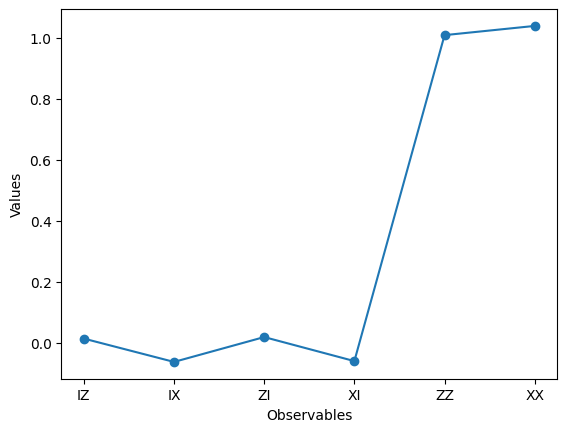

In [32]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.evs

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()